# Model Identification Notebook

In this notebook we will:
- visualize the recorded RSSI reading.
- divide the data into 80% 20%.
- get the RSSI to distance model based on the 80% of the data
- test our model and visualize the errors on the other remaining 20% of data

In [28]:
import pandas as pd

# import the data 
csv_file = '../data/1/FF-FF-30-02-3E-5C.csv'
df = pd.read_csv(csv_file)

df.head()

,distance,rssi
0,1,-39
1,1,-39
2,1,-39
3,1,-45
4,1,-53


In [29]:
# we have 50 readings for each distance
# we need to separate training and testing data for each distance

training_data = pd.DataFrame(
  columns=['distance','rssi']
)
testing_data = pd.DataFrame(
  columns=['distance','rssi']
)

unique_distances = df['distance'].unique()

for distance in df['distance'].unique():
    df_distance = df[df['distance'] == distance]
    df_distance = df_distance.sample(frac=1).reset_index(drop=True)
    # add column counter to keep track of the order of the readings
    df_distance['counter'] = df_distance.index
    training_data = pd.concat([training_data,df_distance[:40]])
    testing_data = pd.concat([testing_data,df_distance[40:]])

# training_data = training_data.reset_index()
# testing_data = testing_data.reset_index()

print("Number of unique distances: ", len(training_data['distance'].unique()))
print("Number of training readings for each distance: ", len(training_data['distance'])/len(training_data['distance'].unique()))
print("Number of testing readings for each distance: ", len(testing_data['distance'])/len(testing_data['distance'].unique()))

# print(training_data)

Number of unique distances:  28
Number of training readings for each distance:  40.0
Number of testing readings for each distance:  10.0


In [30]:

import numpy as np

training_data['rssi'] = abs(training_data['rssi'])
testing_data['rssi'] = abs(testing_data['rssi'])

# sort training_data by rssi
training_data = training_data.sort_values(by=['rssi'])

unique_rssi = np.array(training_data['rssi'].unique(), dtype=np.float64)

median_by_rssi = training_data.groupby('rssi').median()['distance']
mean_by_rssi = training_data.groupby('rssi').mean()['distance']

median_by_rssi = np.array(median_by_rssi, dtype=np.float64)
mean_by_rssi = np.array(mean_by_rssi, dtype=np.float64)


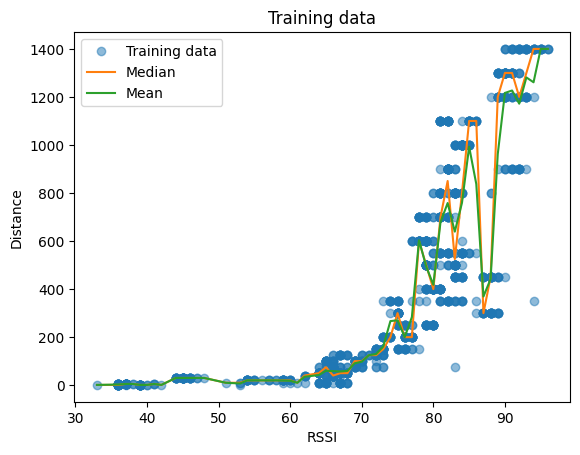

In [31]:
# visualize the data
# plot RSSI vs distance
%matplotlib inline
import matplotlib.pyplot as plt


plt.figure(
  # figsize=(10,10)
)
plt.plot(
  training_data['rssi'],
  training_data['distance'],
  "o",
  alpha=0.5,
)

plt.plot(
  unique_rssi,
  median_by_rssi,  
)

plt.plot(
  unique_rssi,
  mean_by_rssi
)

plt.title("Training data")

plt.ylabel("Distance")
plt.xlabel("RSSI")

plt.legend([
  "Training data",
  "Median",
  "Mean",
])


plt.show()


In [32]:
p = np.polyfit(
    unique_rssi,
    abs(median_by_rssi), 
    4
  )


p
# [-1.53921836e-05,  4.65072912e-03, -5.29947347e-01,  2.87587266e+01,-7.46768727e+02,  7.45399589e+03]


array([-3.68323686e-04,  1.07045001e-01, -1.04700896e+01,  4.22840190e+02,
       -6.03268842e+03])

In [42]:
get_distance = lambda rssi: sum([p[i]*rssi**(len(p)-i-1) for i in range(len(p))])

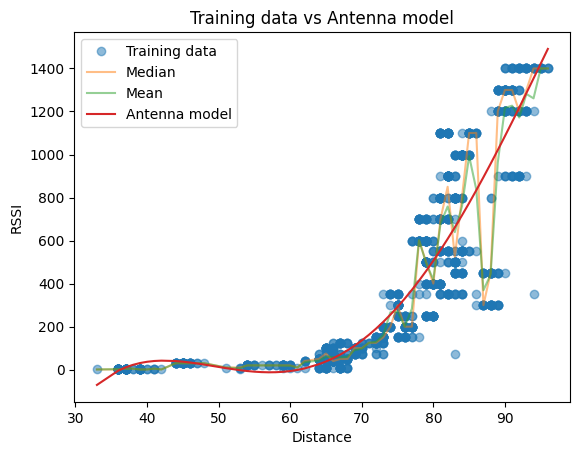

In [43]:
# plot previous plot with logarithmic model

plt.plot(
  training_data['rssi'],
  training_data['distance'],
  "o",
  alpha=0.5,
)

plt.plot(
  unique_rssi,
  median_by_rssi,  
  alpha=0.5
)

plt.plot(
  unique_rssi,
  mean_by_rssi,
  alpha=0.5
)

plt.plot(
  unique_rssi,
  get_distance(unique_rssi),
  "-",
)

plt.title("Training data vs Antenna model")

plt.xlabel("Distance")
plt.ylabel("RSSI")

plt.legend([
  "Training data",
  "Median",
  "Mean",
  "Antenna model"
])

plt.show()

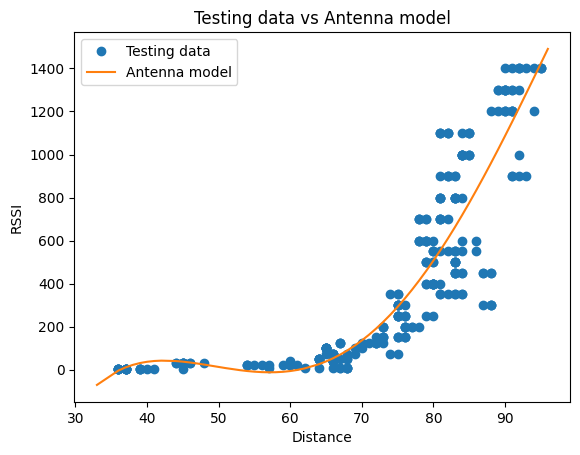

In [46]:
# plot testing data with logarithmic model
plt.plot(
  testing_data["rssi"],
  testing_data["distance"],
  "o"
)
plt.plot(
  unique_rssi,
  get_distance(unique_rssi),
  "-",
)
# plt.plot(
#   testing_data["distance"],
#   testing_data["distance"].apply(get_rssi_2),
# )

plt.title("Testing data vs Antenna model")

plt.xlabel("Distance")
plt.ylabel("RSSI")

plt.legend(["Testing data", "Antenna model"])


plt.show()

Model accuracy: 90.71428571428571%


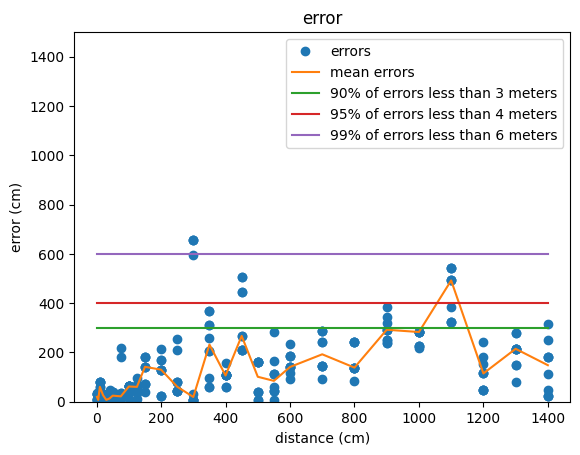

In [56]:
# plot errors

# testing_data = training_data.copy()

testing_data['rssi'] = abs(testing_data['rssi'])
testing_data['predicted_distance'] = testing_data['rssi'].apply(get_distance)
testing_data['error'] = abs(testing_data['distance'] - testing_data['predicted_distance']) #*100 / testing_data['distance']
testing_data['relative_error'] = testing_data['error'] * 100 / testing_data['distance']

error_lim = 3 * 100 # meters

model_accuracy = len(testing_data[testing_data['error'] <= error_lim])* 100 / len(testing_data)
print(f"Model accuracy: {model_accuracy}%")

plt.plot(
  testing_data["distance"],
  testing_data["error"],
  "o"
)

# smoth the plot
plt.plot(
  testing_data["distance"].unique(),
  testing_data.groupby("distance")["error"].median().rolling(1).mean(),
)

plt.plot(
  testing_data["distance"].unique(),
  np.ones(len(testing_data["distance"].unique()))*error_lim,
)
plt.plot(
  testing_data["distance"].unique(),
  np.ones(len(testing_data["distance"].unique()))*4*100,
)
plt.plot(
  testing_data["distance"].unique(),
  np.ones(len(testing_data["distance"].unique()))*6*100,
)

plt.title("error")

plt.ylim(0, 1500)

plt.xlabel("distance (cm)")
plt.ylabel("error (cm)")

plt.legend(["errors", "mean errors", "90% of errors less than 3 meters","95% of errors less than 4 meters","99% of errors less than 6 meters"])

plt.show()